In [38]:
import pandas as pd
import sqlalchemy
import imp

utils = imp.load_source('utils','../utils.py')

%matplotlib inline  
%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


In [7]:
conn = utils.connect_sqlalchemy()

In [8]:
votacao_deputado = pd.read_sql_table('votacao_deputado', conn, schema='a_camdep')

In [9]:
votacao_deputado.head(3)

,codproposicao,tipo,numero,ano,codsessao,datavotacao,idecadastro,nome,partido,uf,voto
0,2141401,REQ,6711,2017,16241,2017-06-13 16:00:00,74784.0,Luiza Erundina,PSOL,SP,Obstrução
1,2141401,REQ,6711,2017,16241,2017-06-13 16:00:00,152610.0,Roberto Alves,PRB,SP,Sim
2,2141401,REQ,6711,2017,16241,2017-06-13 16:00:00,141480.0,Lázaro Botelho,PP,TO,Sim


#### Generate proposal hash

In [32]:
votacao_unique = votacao_deputado.drop_duplicates(subset=['codproposicao', 'codsessao' ,'datavotacao'])[['codproposicao', 'codsessao' ,'datavotacao']]
votacao_unique['votacao_id'] = votacao_unique.apply(lambda x: hash(tuple(x)), axis = 1)
votacao_deputado = votacao_deputado.merge(votacao_unique, on=['codproposicao', 'codsessao' ,'datavotacao'])

#### Analisis of voting data

In [33]:
votacao_deputado.groupby(['voto']).count()['ano']

voto
-             26829
Abstenção      9638
Art. 17        2628
Branco            2
Não          447814
Obstrução     42221
Sim          598431
Name: ano, dtype: int64

We can see that those are the types of votes on the database

- 'Sim' and 'Não' are Yes or No votes

- 'Obstrução' means Obstruction

- 'Abstenção' means Abstention

- 'Art. 17' means Article 17 which refers to prohibts the President of the House from voting

- 'Branco' means Blank vote, but it just appeared once, so it is certantly a mistake.

- '-' corresponds to the absence of the congressman

Since I am interested on congressman with the same behaviour that will form edges on the graph, it seems reasonable to delete the following vote types: 'Art. 17', 'Branco'.

In [35]:
votacao_deputado = votacao_deputado[(votacao_deputado['voto'] != 'Art. 17') &
                 (votacao_deputado['voto'] != 'Branco')]
votacao_deputado.groupby(['voto']).count()['ano']

voto
-             26829
Abstenção      9638
Não          447814
Obstrução     42221
Sim          598431
Name: ano, dtype: int64

1.33633830117


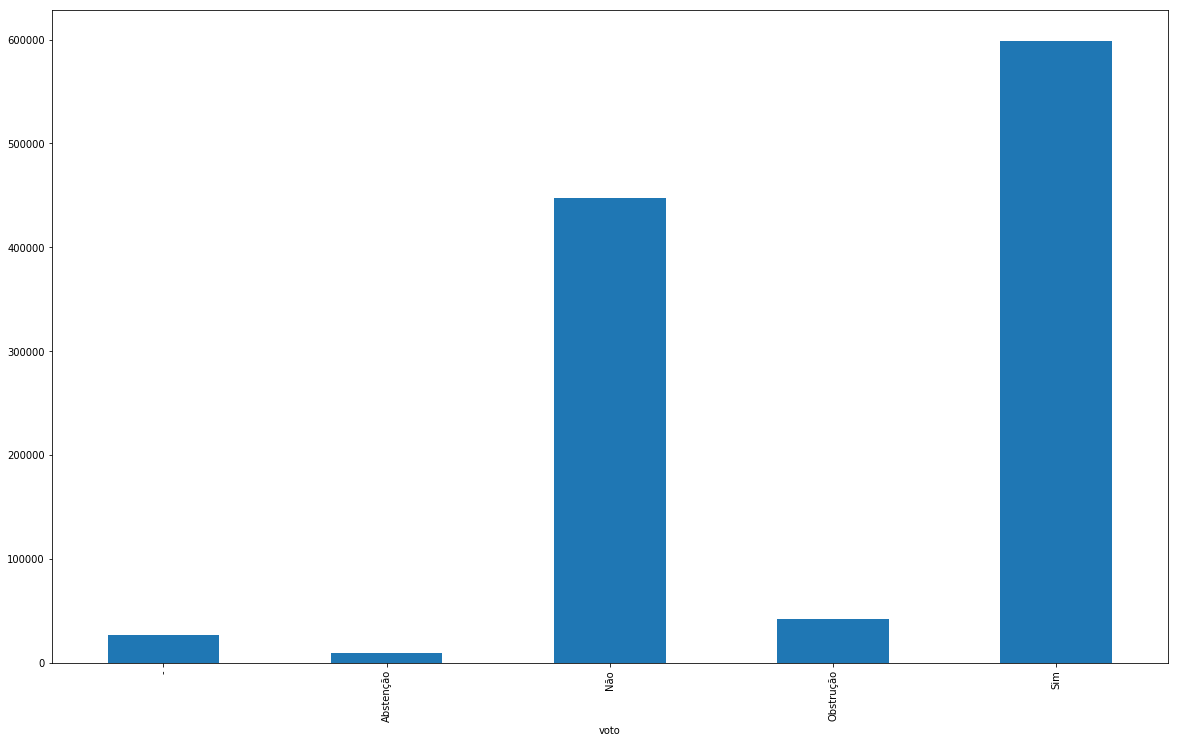

In [40]:
votacoes = votacao_deputado.groupby(['voto']).count()['ano']
print(votacoes['Sim']/votacoes['Não'])
votacao_deputado.groupby(['voto']).count()['ano'].plot(kind='bar')

In [174]:
votacao_deputado_time = votacao_deputado.set_index('datavotacao')
votacao_deputado_temp = votacao_deputado_time.groupby(['votacao_id', 'voto']).count()['codproposicao'].to_frame()

In [175]:
def test(x):
    try:
        s = (x.query('voto == "Sim"'))['codproposicao'].values[0]
    except:
        s=0
    
    try:
        b = (x.query('voto == "Não"'))['codproposicao'].values[0]
    except:
        b=0
    
    try:
        o = (x.query('voto == "Obstrucao"'))['codproposicao'].values[0]
    except:
        o=0
    
    if (b == 0) & (o == 0):
        return None
    else:
        return(s/x.sum())
votacao_deputado_temp = votacao_deputado_temp.groupby(level=0).apply(test)

In [176]:
#votacao_deputado_temp = votacao_deputado_temp.to_frame()
votacao_deputado_temp = votacao_deputado_temp.rename(columns={0:'ratio'}).reset_index()

In [225]:
#votacao_deputado_temp

In [178]:
votacao_ratio = votacao_deputado[['votacao_id','datavotacao']].merge(votacao_deputado_temp, on=['votacao_id']).drop_duplicates(subset=['votacao_id']).set_index('datavotacao')

In [183]:
votacao_ratio.rename(columns={'codproposicao': 'ratio'}, inplace=True)

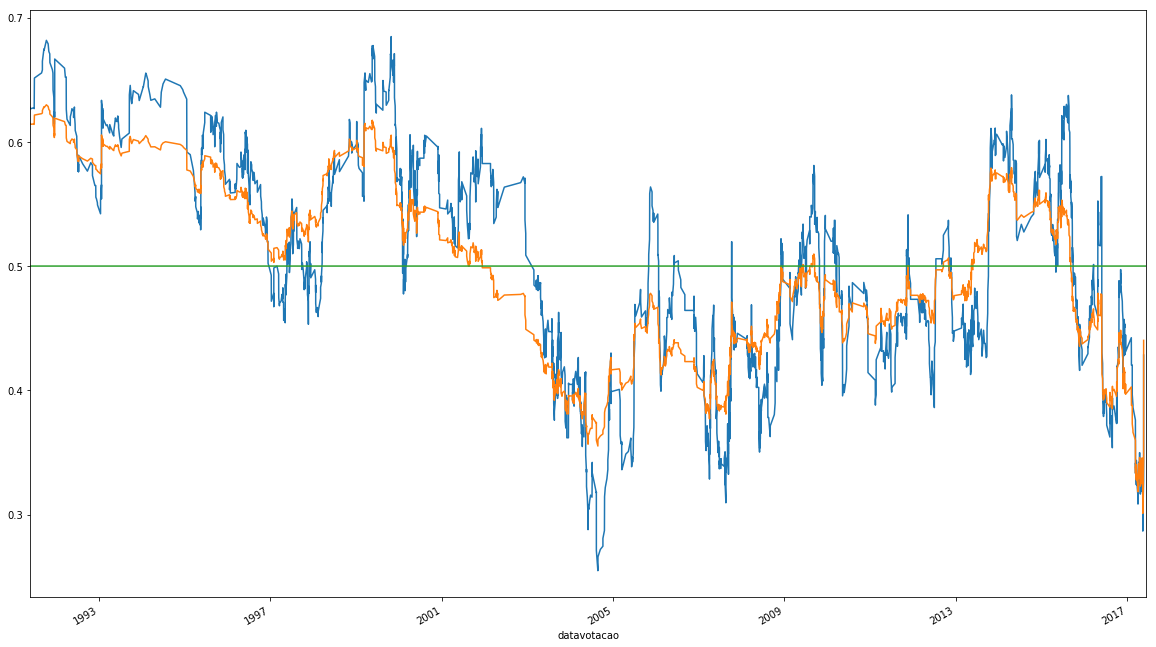

In [188]:
votacao_ratio['ratio'].ewm(halflife=30, min_periods=10).mean().plot()
votacao_ratio['ratio'].ewm(halflife=90, min_periods=10).mean().plot()
votacao_ratio['hline'] =  votacao_ratio.apply(lambda x: 0.5, axis=1)
votacao_ratio['hline'].plot()

In [205]:
v = votacao_deputado[['votacao_id','tipo', 'datavotacao']]
votacao_ratio = votacao_ratio.merge(v, on='votacao_id').drop_duplicates(subset=['votacao_id'])

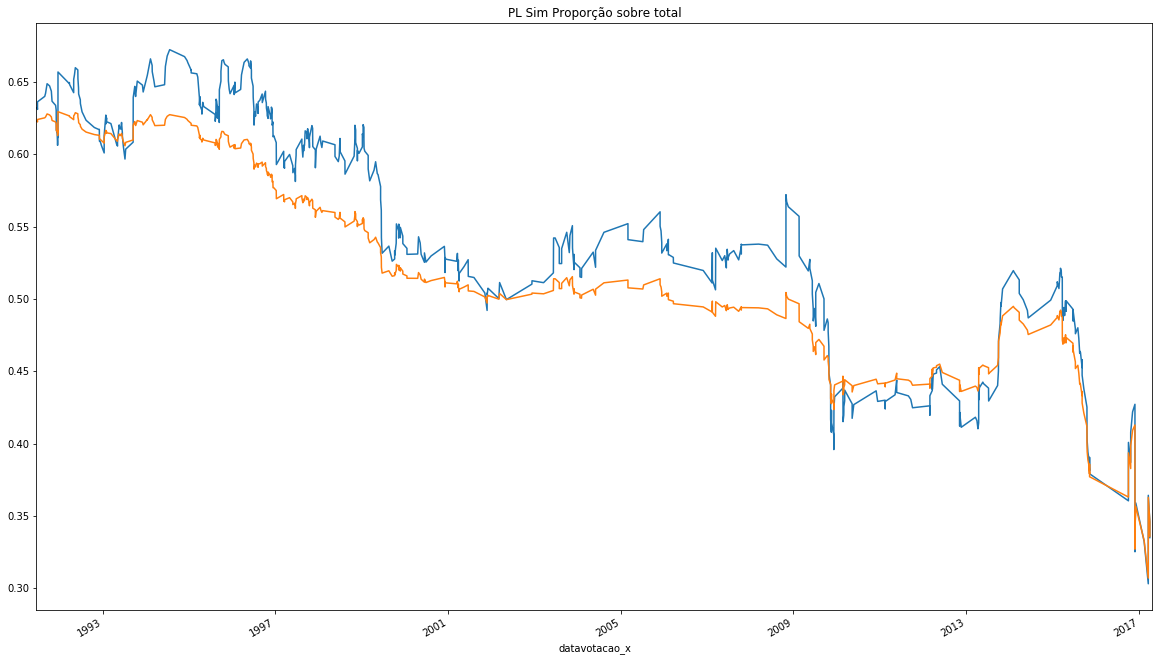

In [220]:
pl = votacao_ratio[votacao_ratio['tipo'] == 'PL']
pl.set_index('datavotacao_x', inplace=True)
pl['ratio'].ewm(halflife=30, min_periods=10).mean().plot()
pl['ratio'].ewm(halflife=90, min_periods=10).mean().plot(title='PL Sim Proporção sobre total')

In [ ]:
pl.resample('M').

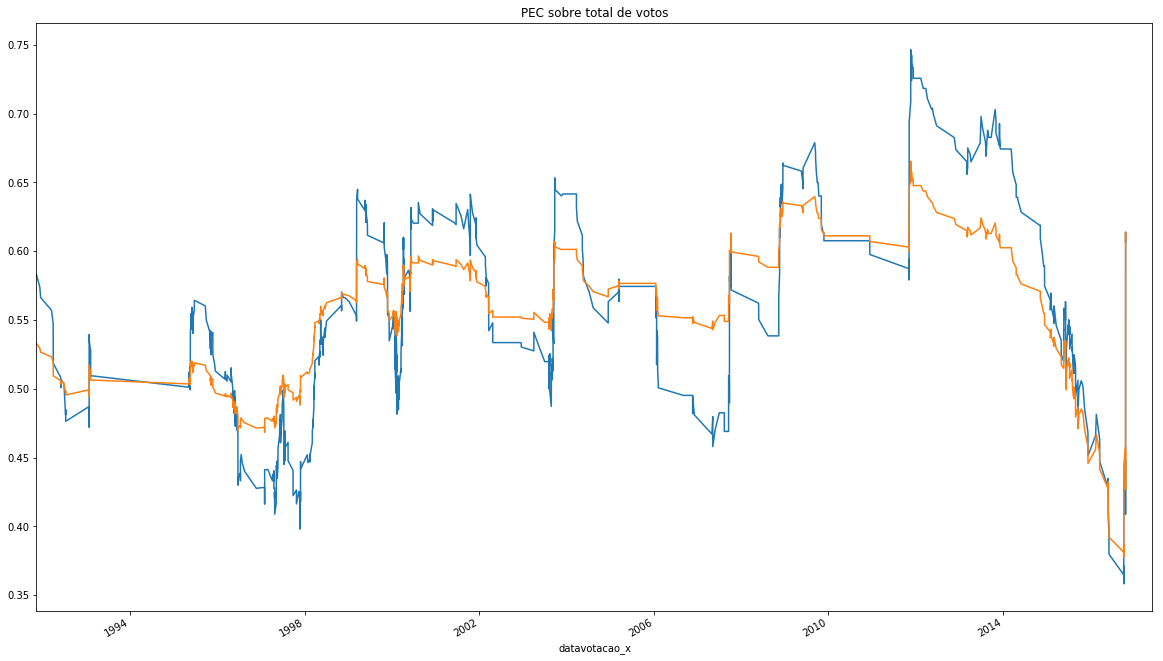

In [221]:
pec = votacao_ratio[votacao_ratio['tipo'] == 'PEC']
pec.set_index('datavotacao_x', inplace=True)
pec['ratio'].ewm(halflife=30, min_periods=10).mean().plot()
pec['ratio'].ewm(halflife=90, min_periods=10).mean().plot(title='PEC sobre total de votos')

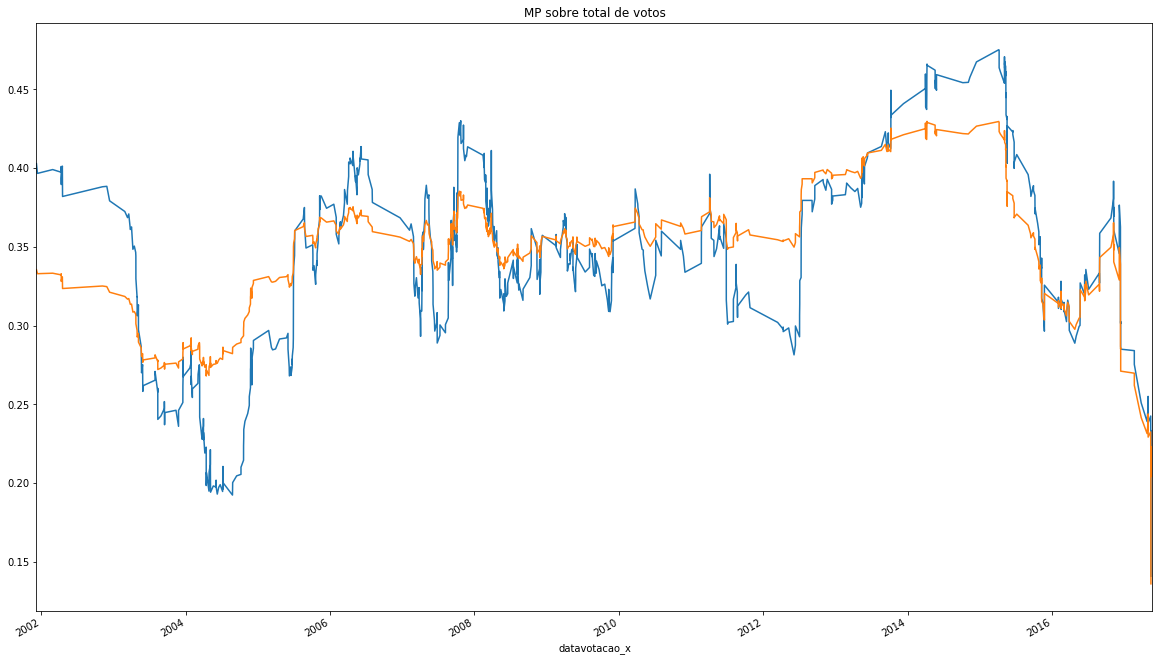

In [222]:
mp = votacao_ratio[votacao_ratio['tipo'] == 'MPV']
mp.set_index('datavotacao_x', inplace=True)
mp['ratio'].ewm(halflife=30, min_periods=10).mean().plot()
mp['ratio'].ewm(halflife=90, min_periods=10).mean().plot(title='MP sobre total de votos')